# How Many Books?

Suppose you are the author of a book like *Probably Overthinking It*, and when you visit a local bookstore, like Newtonville Books in Newton, MA, you see that they have two copies of your book on display.

Is it good that they have only a few copies, because it suggests they started with more and sold some? Or is it bad because it suggests they only keep a small number in stock, and they have not sold. More generally, what number of books would you like to see?

To answer these questions, we have to make some modeling decisions. To keep it simple, I'll assume:

* The bookstore orders books on some regular cycle of unknown duration.

* At the beginning of every cycle, they start with `k` books.

* People buy the book at a rate of `λ` books per cycle.

* When you visit the store, you arrive at a random time `t` during the cycle.

We'll start by defining prior distributions for these parameters, and then we'll update it with the observed data. Here are some libraries we'll need.

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

## Priors

For some books, the store only keeps one copy in stock. For others it might keep as many as ten. If we would be equally unsurprised by any value in this range, the prior distribution of `k` is uniform between `1` and `10`.

In [4]:
ks = np.arange(1, 11)
prior_k = Pmf(1, ks)
prior_k.normalize()
prior_k.index.name = 'k'

If we arrive at a random point in the cycle, the prior distribution of `t` is uniform between `0` and `1`, measured in cycles.

In [5]:
ts = np.linspace(0, 1, 21)
prior_t = Pmf(1, ts)
prior_t.normalize()
prior_t.index.name = 't'

Now let's figure the book-buying rate is probably between `2` and `3` copies per cycle, but it could be substantially higher -- with low probability.
We can choose a lognormal distribution that has a mean and shape that seem reasonable.

In [6]:
from scipy.stats import norm

λs = np.linspace(0.01, 20, 50)
qs = np.log(λs)

mu, sigma = 0.3, 0.7
ps = norm.pdf(qs, mu, sigma)

prior_λ = Pmf(ps, λs)
prior_λ.normalize()
prior_λ.index.name = 'λ'

prior_λ.mean()

2.7952013319456332

Here's what it looks like.

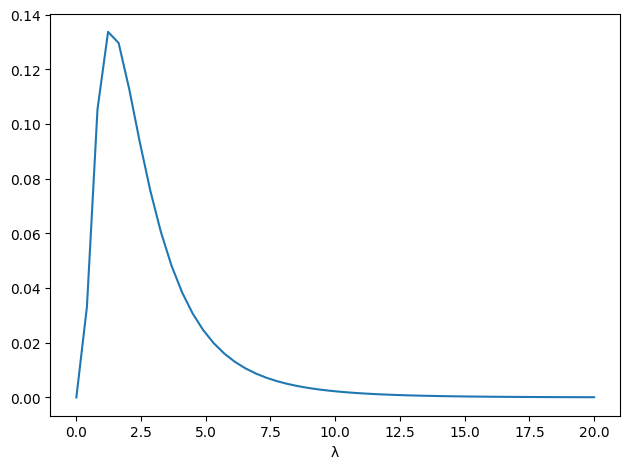

In [7]:
prior_λ.plot()
decorate()

To form the joint prior distribution, I'll use `meshgrid` with the `ij` indexing order, which  makes the order of the dimensions the same as the order of the arguments: `k`, `λ`, `t`.

In [8]:
def meshgrid(*args, **options):
    if 'indexing' not in options:
        options['indexing'] = 'ij'
    return np.meshgrid(*args, **options)

In [9]:
PK, Pλ, PT = meshgrid(prior_k, prior_λ, prior_t)
prior = PK * Pλ * PT
prior.shape

(10, 50, 21)

## The update

Now for the update, we have to handle two cases:

* If we observe at least one book, `n`, the probability of the data is the probability of selling `k-n` books at rate `λ` over period `t`, which is given by the Poisson PMF.

* If there are no copies left, we have to add in the probability that the number of books sold in this period could have exceeded `k`, which is given by the Poisson survival function.

The following function computes the probability of the data for all values of the parameters, multiplies by the prior, and normalizes the result.

In [10]:
from scipy.stats import poisson

def update(prior, n):
    K, λ, T = meshgrid(ks, λs, ts)
    
    like = poisson(mu=λ*T).pmf(K-n)
    if n == 0:
        like += poisson(mu=λ*T).sf(K)

    posterior = prior * like
    posterior /= posterior.sum()
    
    return posterior

As an example, we'll do an update with the hypothetically observed `2` books.

In [11]:
n = 2
posterior = update(prior, n)

From the joint posterior, we can extract the marginal distributions of `k` and `λ`, and compute their means.

In [12]:
posterior_k = Pmf(posterior.sum(axis=(1, 2)), ks)
posterior_λ = Pmf(posterior.sum(axis=(0, 2)), λs)

posterior_k.mean(), posterior_λ.mean()

(3.294088962095148, 2.720709517121936)

Seeing two books suggests that the store starts each cycle with 3-4 books and sells 2-3 per cycle. Here's the posterior distribution of `k` compared to its prior.

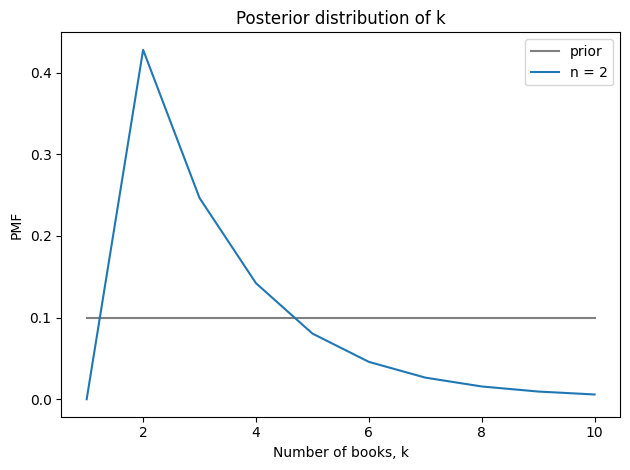

In [13]:
prior_k.plot(label=f'prior', color='gray')
posterior_k.plot(label=f'n = {n}')
decorate(xlabel='Number of books, k',
         ylabel='PMF',
         title='Posterior distribution of k')

And here's the posterior distribution of `λ`.

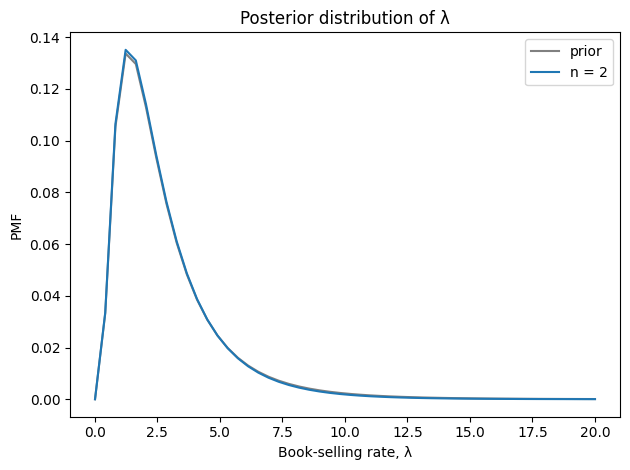

In [14]:
prior_λ.plot(label='prior', color='gray')
posterior_λ.plot(label=f'n = {n}')
decorate(xlabel='Book-selling rate, λ',
         ylabel='PMF',
         title='Posterior distribution of λ')

Seeing two books doesn't provide much information about the book-selling rate.

## Optimization

Now let's consider the more general question, "What number of books would you most like to see?" There are two ways we might answer:

* One answer might be the observation that leads to the highest estimate of `λ`. But if the book-selling rate is high, relative to `k`, the book will sometimes be out of stock, leading to lost sales.

* So an alternative is to choose the observation that implies the highest number of books sold per cycle.

To compute the second one, we'll need the following function, which makes a `Pmf` that represents the distribution of books sold during one cycle with rate `λ` and upper bound `k`.

In [15]:
def make_poisson(λ, k):
    """Make a truncated Poisson distribution.
    """
    qs = np.arange(k+1)
    ps = poisson.pmf(qs, λ)
    pmf = Pmf(ps, qs)
    
    # assign the total probability mass above `k` to `k`.
    pmf[k] += poisson.sf(k, λ)
    return pmf

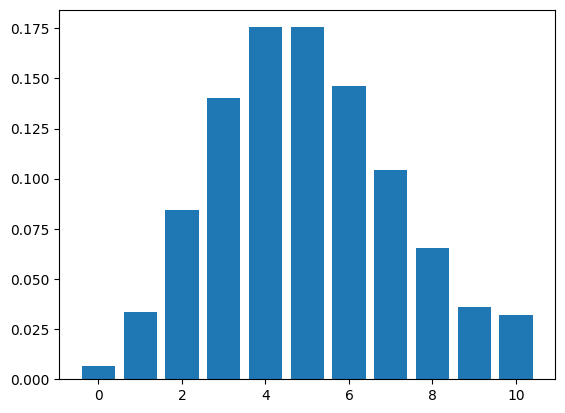

In [16]:
pmf = make_poisson(5, 10)
pmf.bar()

Now if we are given a posterior distribution, we can compute the expected sales for each pair of parameters and make a Pmf that maps from each expectation to its probability.

In [17]:
def compute_sales(posterior):
    """Expected number of books sold per cycle.
    
    posterior: array of posterior probabilities for k, λ, t
    """
    # make the marginal joint posterior of k, λ
    posterior_joint = pd.DataFrame(posterior.sum(axis=2), 
                                   index=ks, columns=λs)

    res = []
    for (k, lam), p in posterior_joint.stack().items():
        exp_sales = make_poisson(lam, k).mean()
        res.append((p, exp_sales))
        
    ps, qs = np.transpose(res)
    pmf = Pmf(ps, qs)
    return pmf.mean()

In [18]:
compute_sales(posterior)

2.0364396231583672

Finally, let's loop over possible value of `n` and compute for each one the posterior mean values of `k` and `λ`

In [19]:
res = []

for n in range(11):
    posterior = update(prior, n)
    posterior_k = Pmf(posterior.sum(axis=(1, 2)), ks)
    posterior_λ = Pmf(posterior.sum(axis=(0, 2)), λs)

    k, λ = posterior_k.mean(), posterior_λ.mean()
    sales = compute_sales(posterior)
    res.append((n, k, λ, sales))

df = pd.DataFrame(res, columns=['n', 'mean k', 'mean λ', 'exp sales'])
df

,n,mean k,mean λ,exp sales
0,0,2.409571,4.361937,2.025360
1,1,2.322331,2.740616,1.643844
2,2,3.294089,2.720710,2.036440
3,3,4.254728,2.693604,2.269578
4,4,5.199590,2.656726,2.393205
5,5,6.122093,2.606749,2.441859
6,6,7.013147,2.539618,2.435680
7,7,7.860703,2.450961,2.384995
8,8,8.649959,2.337343,2.295145
9,9,9.365430,2.199540,2.172083


Here's the implied sales rate as a function of the observed number of books.
By this metric, the best number of books to see is `0`.

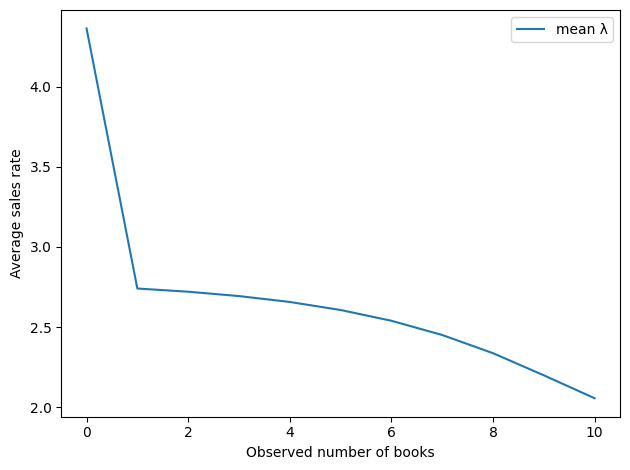

In [20]:
df['mean λ'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Average sales rate')

And here's the implied number of books sold per cycle.

5

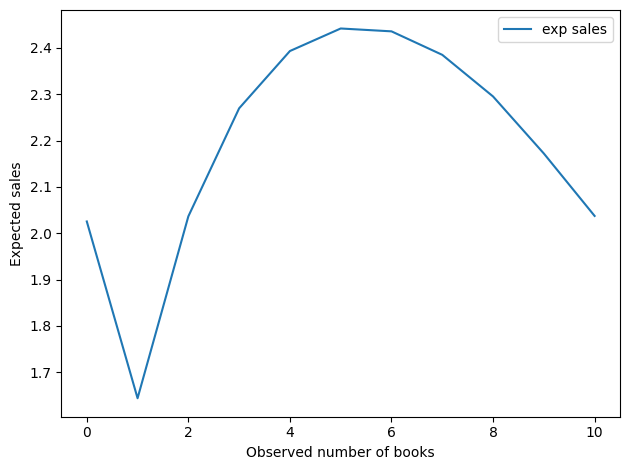

In [21]:
df['exp sales'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Expected sales')
df['exp sales'].argmax()

This result is a little more interesting.
Seeing `0` books is still good, but the optimal value is around `5`.

Now, we should not take this value too seriously, as it is based on a very small amount of data and a lot of assumptions -- both in the model and in the priors.
But it is interesting that the optimal point is neither `0` nor "as many as possible".

Thanks to Aubrey Clayton for [this tweet](https://twitter.com/aubreyclayton/status/1735467931490734251), which gave me the idea for this article.

Copyright 2023 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)